# Financial Modeling with Python

In this notebook we will use algorithms and/or statistical tests to automatically identify potential issues (like outliers) and analyze the data for the existence of trends or other patterns (for example, mean-reversion).
We will also dive deeper into the stylized facts of asset returns. Together with outlier detection, those recipes are particularly important when working with financial data. When we want to build models/ strategies based on asset prices, we have to make sure that they can accurately capture the dynamics of the returns.

## 1. Outlier Detection

In the financial domain, **outlier** can be the result of a wrong price, something major happening in the financial markets, or an error in the data processing pipeline. Many machine learning algorithms and statistical approaches can be heavily influenced by outliers, leading to incorrect/biased results. That is why we should identify and handle the outliers before creating any models.

### 1.1 Outlier Detection using Rolling Statistics
In this section, we cover a relatively simple, filter-like approach to detect outliers based on the rolling average and standard deviation. We will use Tesla’s stock prices from the years 2019 to 2020.


1. Import the libraries:

In [129]:
import pandas as pd
import yfinance as yf

2. Download the data, compute the simple return and make a copy of only the return column:

In [132]:
df = yf.download("TSLA",
                 start="2019-01-01",
                 end="2020-12-31",
                 auto_adjust=True,
                 progress=False)
df["rtn"] = df["Close"].pct_change()
df = df[["rtn"]].copy()
df.head()

Price,rtn
Ticker,
Date,
2019-01-02,NaN
2019-01-03,-0.031472
2019-01-04,0.057697
2019-01-07,0.054361
2019-01-08,0.001164


3. Drop the Ticker (it is multi-index):

In [135]:
df.columns = df.columns.droplevel([1])
df.head()

Price,rtn
Date,
2019-01-02,NaN
2019-01-03,-0.031472
2019-01-04,0.057697
2019-01-07,0.054361
2019-01-08,0.001164


4. Calculate the 21-day rolling mean and standard deviation:

In [138]:
df_rolling = df[["rtn"]].rolling(window=21).agg(["mean", "std"])
df_rolling.columns = df_rolling.columns.droplevel()
df_rolling.tail()

,mean,std
Date,,
2020-12-23,0.011014,0.041006
2020-12-24,0.009119,0.039307
2020-12-28,0.007660,0.038922
2020-12-29,0.006850,0.038819
2020-12-30,0.010384,0.038578


5. Join the rolling window back to the initial DataFrame:

In [141]:
df = df.join(df_rolling)
df.head()

,rtn,mean,std
Date,,,
2019-01-02,NaN,NaN,NaN
2019-01-03,-0.031472,NaN,NaN
2019-01-04,0.057697,NaN,NaN
2019-01-07,0.054361,NaN,NaN
2019-01-08,0.001164,NaN,NaN


6. Calculate the upper and lower thresholds:

In [144]:
N_SIGMAS = 3
df["upper"] = df["mean"] + N_SIGMAS * df["std"]
df["lower"] = df["mean"] - N_SIGMAS * df["std"]

7. Identify the outliers using the previously calculated thresholds:

In [147]:
df["outlier"] = (
    (df["rtn"] > df["upper"]) | (df["rtn"] < df["lower"])
)

8. Plot the returns together with threshold and mark the outliers:

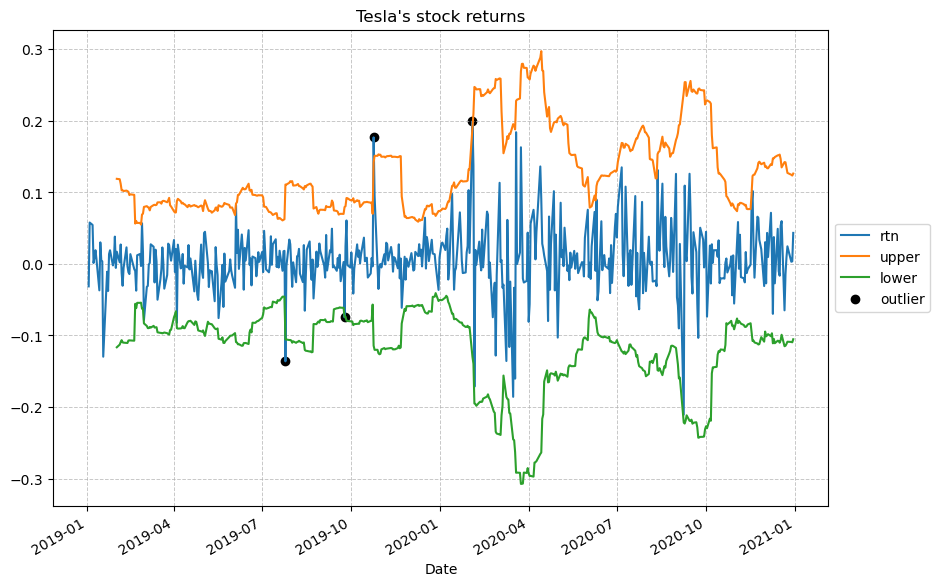

In [150]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,7))
df[["rtn", "upper", "lower"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier"]].index,
           df.loc[df["outlier"], "rtn"],
           color="black", label="outlier")
ax.set_title("Tesla's stock returns")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

In the plot, we can observe outliers marked with a black dot, together with the thresholds used for determining them. One thing to notice is that when there are two large (in absolute terms) returns in the vicinity of one another, the algorithm identifies the first one as an outlier and the second one as a regular observation. This might be due to the fact that the first outlier enters the rolling window and affects the moving average/standard deviation. We can observe a situation like that in the first quarter of 2020.

## Outlier Function
In the previous section, we demonstrated how to carry out all the steps required for identifying the outliers as separate operations on the DataFrame. However, we can quickly encapsulate all of the steps into a single function and make it generic to handle more use cases. You can find an example of how to do so below:

In [154]:
def identify_outliers(df, column, window_size, n_sigmas):
    """Function for identifying outliers using rolling statistics"""
    df = df[[column]].copy()
    df.columns = df.columns.droplevel([1])
    df_rolling = df.rolling(window=window_size).agg(["mean", "std"])
    df_rolling.columns = df_rolling.columns.droplevel()
    df = df.join(df_rolling)
    df["upper"] = df["mean"] + n_sigmas * df["std"]
    df["lower"] = df["mean"] - n_sigmas * df["std"]
    return ((df[column] > df["upper"]) | (df[column] < df["lower"]))

Benefit of using a function is that you can easily experiement with different parameters like window_size and n_sigmas. 

### To Students:
1. Try the function
2. What percentage of the data is an outlier?

### 1.2 Outlier detection with the Hampel filter

Hampel filter goal is to identify and potentially replace outliers in a given series. It uses a centered sliding window of size $2x$ (given $x$ observations before/after) to go over the entire series.

For each of the sliding windows, the algorithm calculates the median and the median absolute deviation (a form of a standard deviation).

Similar to the previously covered algorithm, we treat an observation as an outlier if it differs from the window’s median by more than a determined number of standard deviations. We can then replace such an observation with the window’s median.

We can experiment with the different settings of the algorithm’s hyperparameters. For example, a higher standard deviation threshold makes the filter more forgiving, while a lower one results in more data points being classified as outliers.

Let us consider Tesla’s prices from 2019 to 2020:

1. Install the required module:

In [ ]:
pip install sktime

2. import the libraries:

In [159]:
import yfinance as yf
from sktime.transformations.series.outlier_detection import HampelFilter

3. Download the Tesla's stock prices from the year 2019 to 2020 and calculate simple return:

In [162]:
df = yf.download("TSLA",
                 start="2019-01-01",
                 end="2020-12-31",
                 auto_adjust=True,
                 progress=False)
df["rtn"] = df["Close"].pct_change()

4. Instantiate the HampelFilter class and use it for detecting the outliers:

In [165]:
hampel_detector = HampelFilter(window_length=10,
                               return_bool=True)
df["outlier"] = hampel_detector.fit_transform(df["Close"])

5. Plot the Tesla's stock prices and mark the outliers:

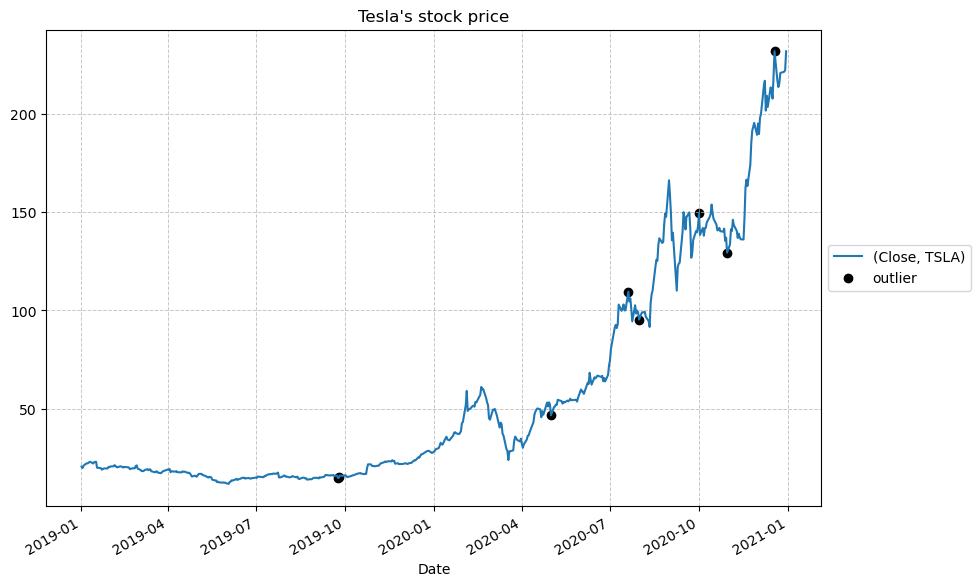

In [168]:
fig, ax = plt.subplots()
df[["Close"]].plot(ax=ax, figsize=(10,7))
ax.scatter(df.loc[df["outlier"]].index,
           df.loc[df["outlier"], "Close"],
           color="black", label="outlier")
ax.set_title("Tesla's stock price")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

Using the Hampel filter, we identified seven outliers. At first glance, it might be interesting and maybe even a bit counterintuitive that the biggest spike and drop around September 2020 were not detected, but some smaller jumps later on were. We have to remember that this filter uses a centered window, so while looking into the observation at the peak of the spike, the algorithm also looks at the previous and next five observations, which include high values as well.

### Return Outliers

For comparison’s sake, we can also apply the very same filter to the returns calculated using the adjust- ed close prices. This way, we can see if the algorithm will identify different observations as outliers:

1. Identify the outliers among returns:

In [173]:
df["outlier_rtn"] = hampel_detector.fit_transform(df["rtn"])

/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/series/outlier_detection.py:96: UserWarning: Series contains nan values, more nan might be
                added if there are outliers
  return self._transform_series(Z)


2. Plot Tesla's daily returns and mark the ouutliers:

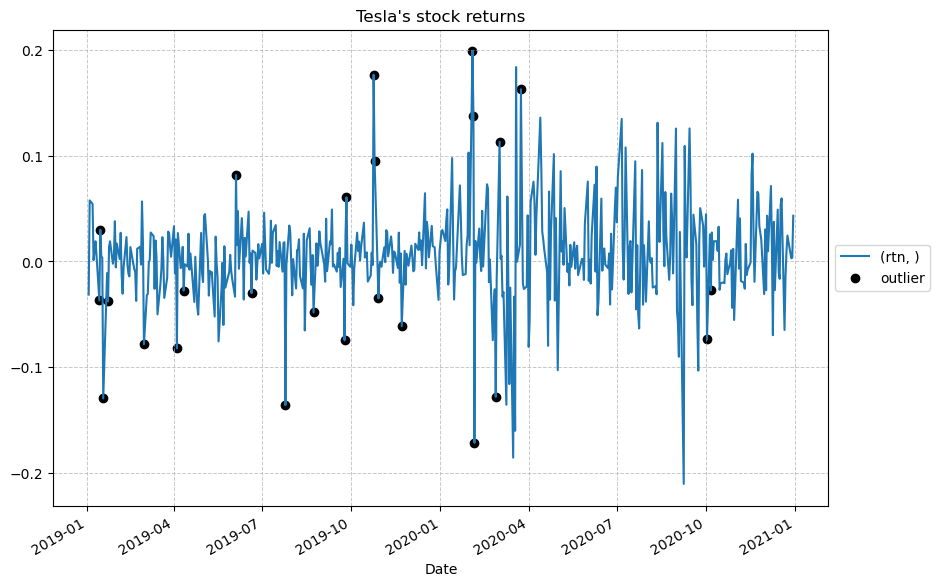

In [177]:
fig, ax = plt.subplots(figsize=(10,7))
df[["rtn"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier_rtn"]].index,
           df.loc[df["outlier_rtn"], "rtn"],
           color="black", label="outlier")
ax.set_title("Tesla's stock returns")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

3. Investigate the overlap in outliers identified for the prices and returns:

In [196]:
df1=df.copy()
df1.columns = df1.columns.droplevel([1])
df1.query("outlier == True and outlier_rtn == True")

Price,Close,High,Low,Open,Volume,rtn,outlier,outlier_rtn
Date,,,,,,,,
2019-09-24,14.880667,16.132668,14.840667,16.101334,193372500,-0.074701,True,True
